# 🏦 Análisis de KPIs

Este notebook analiza un dataset de 1000 transacciones bancarias realizadas el 17/01/2025 en un lapso de 10:00 a 11:00 am y muestra:

- Detección de Fraude
- Rendimiento de Red
- Patrones de Transacciones
- Segmentación de Clientes


In [145]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar el archivo
df = pd.read_csv("transaction_data.csv", parse_dates=["Timestamp"])

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 14 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   Transaction ID                    1000 non-null   object        
 1   Sender Account ID                 1000 non-null   object        
 2   Receiver Account ID               1000 non-null   object        
 3   Transaction Amount                1000 non-null   float64       
 4   Transaction Type                  1000 non-null   object        
 5   Timestamp                         1000 non-null   datetime64[ns]
 6   Transaction Status                1000 non-null   object        
 7   Fraud Flag                        1000 non-null   bool          
 8   Geolocation (Latitude/Longitude)  1000 non-null   object        
 9   Device Used                       1000 non-null   object        
 10  Network Slice ID                  1000 non-null  

In [146]:
print(df.head())

  Transaction ID Sender Account ID Receiver Account ID  Transaction Amount  \
0  TXN9520068950          ACC14994            ACC16656              495.90   
1  TXN9412011085          ACC58958            ACC32826              529.62   
2  TXN4407425052          ACC56321            ACC92481              862.47   
3  TXN2214150284          ACC48650            ACC76457             1129.88   
4  TXN4247571145          ACC60921            ACC11419              933.24   

  Transaction Type           Timestamp Transaction Status  Fraud Flag  \
0          Deposit 2025-01-17 10:14:00             Failed        True   
1       Withdrawal 2025-01-17 10:51:00            Success       False   
2       Withdrawal 2025-01-17 10:50:00             Failed       False   
3         Transfer 2025-01-17 10:56:00            Success        True   
4          Deposit 2025-01-17 10:25:00            Success        True   

  Geolocation (Latitude/Longitude) Device Used Network Slice ID  Latency (ms)  \
0          

# Detección de Fraude

In [147]:
# Tasa de fraude
fraud_rate = df['Fraud Flag'].mean() * 100
print(f"💡 Tasa de fraude global: {fraud_rate:.2f}% ({df['Fraud Flag'].sum()} casos)")

# Fraude por tipo de transacción
fraud_by_type = pd.crosstab(df['Transaction Type'], df['Fraud Flag'], normalize='index') * 100
print("\n🔄 Fraude por tipo de transacción (%):")
print(fraud_by_type.sort_values(by=[True], ascending=False))

💡 Tasa de fraude global: 48.10% (481 casos)

🔄 Fraude por tipo de transacción (%):
Fraud Flag            False      True 
Transaction Type                      
Deposit           47.151899  52.848101
Withdrawal        53.548387  46.451613
Transfer          54.545455  45.454545


In [148]:
def extract_coords(geo_str):
    lat_part, lon_part = geo_str.split(', ')
    lat = float(lat_part[:-2])  # Elimina el último espacio y letra
    lon = float(lon_part[:-2])  # Ejemplo: "-74.006 W" -> -74.006
    return lat, lon

df['Latitude'] = df['Geolocation (Latitude/Longitude)'].apply(lambda x: extract_coords(x)[0])
df['Longitude'] = df['Geolocation (Latitude/Longitude)'].apply(lambda x: extract_coords(x)[1])


🚨 0 transacciones en ubicaciones extremas (potencial fraude)
Series([], Name: count, dtype: int64)


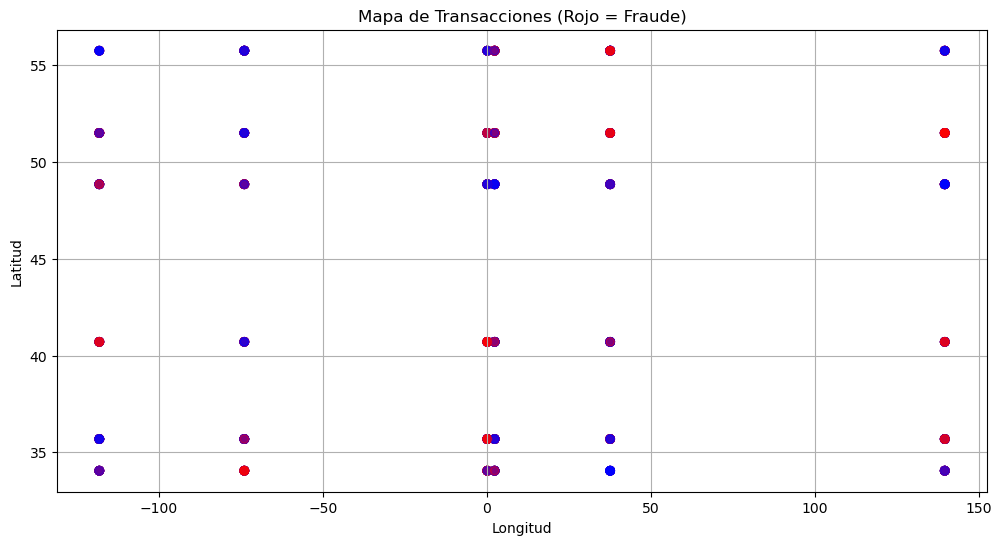

In [149]:

lat_threshold = (df['Latitude'].quantile(0.01), df['Latitude'].quantile(0.99))
lon_threshold = (df['Longitude'].quantile(0.01), df['Longitude'].quantile(0.99))

outliers = df[
    ~df['Latitude'].between(*lat_threshold) | 
    ~df['Longitude'].between(*lon_threshold)
]

print(f"\n🚨 {len(outliers)} transacciones en ubicaciones extremas (potencial fraude)")
print(outliers[['Transaction Amount', 'Fraud Flag']].value_counts())

plt.figure(figsize=(12, 6))
plt.scatter(
    df['Longitude'], 
    df['Latitude'], 
    c=df['Fraud Flag'].map({True: 'red', False: 'blue'}),
    alpha=0.5
)
plt.title("Mapa de Transacciones (Rojo = Fraude)")
plt.xlabel("Longitud")
plt.ylabel("Latitud")
plt.grid()
plt.show()

In [150]:
print("\n📱 Dispositivos asociados a fraude:")
print(df.groupby('Device Used')['Fraud Flag'].mean().sort_values(ascending=False))

print("\n🌐 Slices de red con mayor fraude:")
print(df.groupby('Network Slice ID')['Fraud Flag'].mean().sort_values(ascending=False).head(3))


📱 Dispositivos asociados a fraude:
Device Used
Mobile     0.512476
Desktop    0.446764
Name: Fraud Flag, dtype: float64

🌐 Slices de red con mayor fraude:
Network Slice ID
Slice2    0.508824
Slice3    0.486647
Slice1    0.445820
Name: Fraud Flag, dtype: float64


# Rendimiento de Red

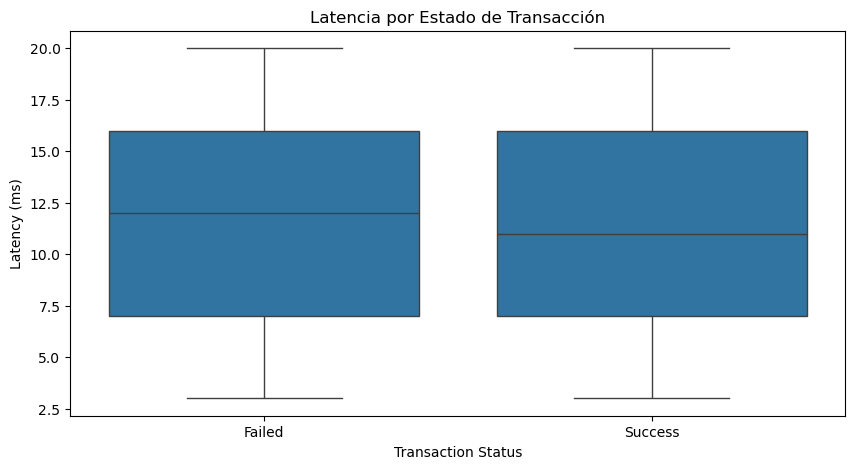


⏳ Latencia promedio por Network Slice ID:
                  count       mean       std  min  25%   50%   75%   max
Network Slice ID                                                        
Slice2            340.0  11.300000  5.079138  3.0  7.0  11.0  15.0  20.0
Slice3            337.0  11.860534  5.029214  3.0  8.0  12.0  16.0  20.0
Slice1            323.0  11.916409  5.283498  3.0  7.0  12.0  17.0  20.0


In [151]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='Transaction Status', y='Latency (ms)')
plt.title("Latencia por Estado de Transacción")
plt.show()

# Latencia en slices de red
print("\n⏳ Latencia promedio por Network Slice ID:")
print(df.groupby('Network Slice ID')['Latency (ms)'].describe().sort_values(by='mean'))


🔴 513 transacciones fallidas (51.3%)


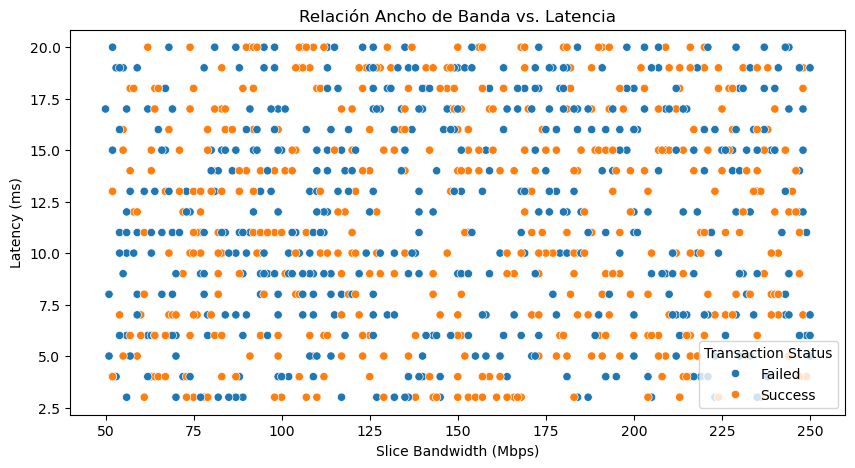

In [152]:
failed_trans = df[df['Transaction Status'] == 'Failed']
print(f"\n🔴 {len(failed_trans)} transacciones fallidas ({(len(failed_trans)/1000)*100:.1f}%)")

plt.figure(figsize=(10, 5))
sns.scatterplot(data=df, x='Slice Bandwidth (Mbps)', y='Latency (ms)', hue='Transaction Status')
plt.title("Relación Ancho de Banda vs. Latencia")
plt.show()

# Patrones de Transacciones

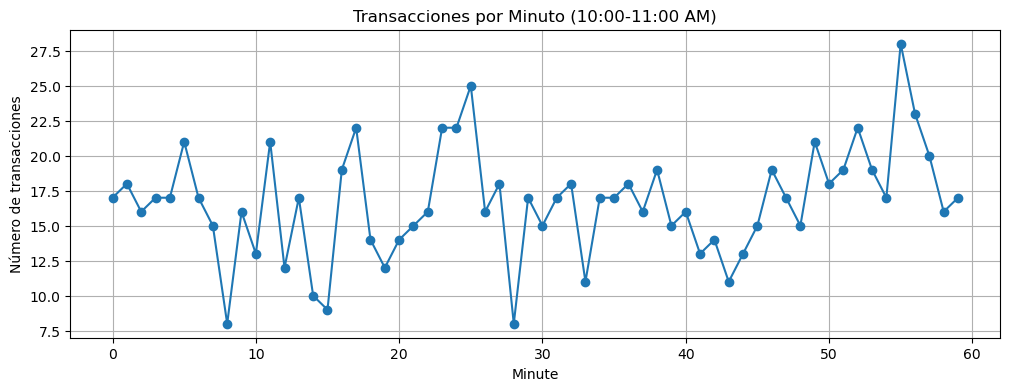

In [153]:
df['Minute'] = df['Timestamp'].dt.minute
trans_per_min = df.groupby('Minute')['Transaction ID'].count()

plt.figure(figsize=(12, 4))
trans_per_min.plot(marker='o')
plt.title("Transacciones por Minuto (10:00-11:00 AM)")
plt.ylabel("Número de transacciones")
plt.grid()
plt.show()


💰 Top 5 transacciones con montos más altos:
    Transaction Type  Transaction Amount  Fraud Flag
240         Transfer             1497.76        True
78          Transfer             1495.01        True
655          Deposit             1494.20        True
514         Transfer             1494.03        True
901         Transfer             1494.01       False


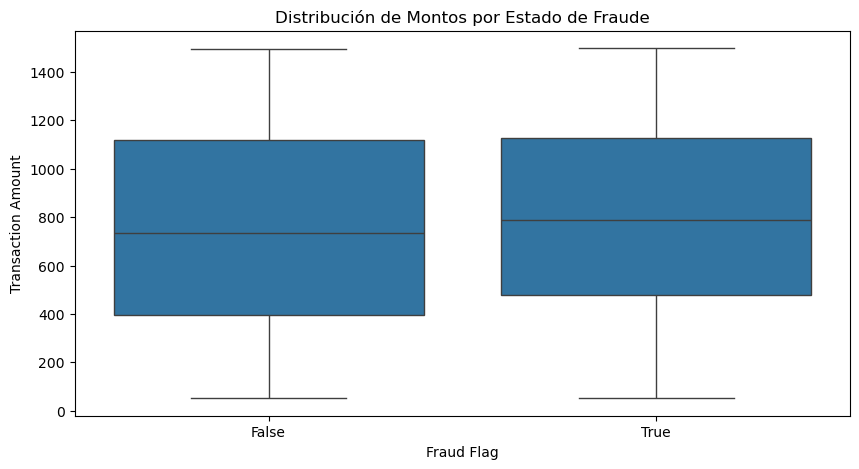

In [154]:
# Top 5 montos más altos
print("\n💰 Top 5 transacciones con montos más altos:")
print(df.nlargest(5, 'Transaction Amount')[['Transaction Type', 'Transaction Amount', 'Fraud Flag']])

# Distribución de montos por fraude
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='Fraud Flag', y='Transaction Amount')
plt.title("Distribución de Montos por Estado de Fraude")
plt.show()

# Segmentación de Clientes

In [155]:
top_senders = df['Sender Account ID'].value_counts().head(5)
top_receivers = df['Receiver Account ID'].value_counts().head(5)

print("\n🔝 Top 5 cuentas emisoras:")
print(top_senders)

print("\n🔝 Top 5 cuentas receptoras:")
print(top_receivers)


🔝 Top 5 cuentas emisoras:
Sender Account ID
ACC37810    2
ACC82828    2
ACC89865    2
ACC75741    2
ACC71245    2
Name: count, dtype: int64

🔝 Top 5 cuentas receptoras:
Receiver Account ID
ACC51253    2
ACC17647    2
ACC85405    2
ACC76710    2
ACC51744    2
Name: count, dtype: int64


In [156]:
# Parejas sender-receiver frecuentes
suspicious_pairs = df.groupby(['Sender Account ID', 'Receiver Account ID']).size().sort_values(ascending=False).head(5)
print("\n🤝 Parejas sender-receiver más frecuentes:")
print(suspicious_pairs)


🤝 Parejas sender-receiver más frecuentes:
Sender Account ID  Receiver Account ID
ACC10043           ACC88019               1
ACC69928           ACC15272               1
ACC69257           ACC16905               1
ACC69369           ACC27407               1
ACC69574           ACC42196               1
dtype: int64


C:\Users\ldijo\AppData\Local\Temp\ipykernel_844\1988311634.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


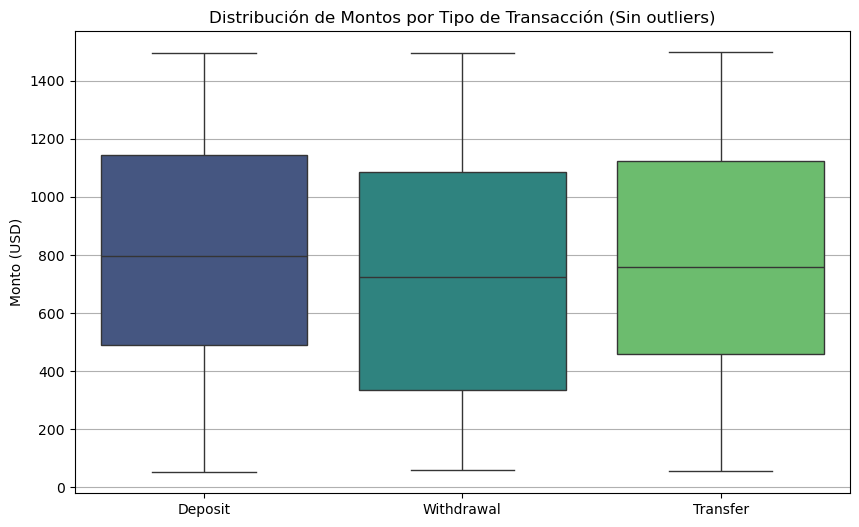

In [157]:
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=df,
    x='Transaction Type',
    y='Transaction Amount',
    palette='viridis',
    showfliers=False  # Oculta valores extremos para mejor visualización
)
plt.title('Distribución de Montos por Tipo de Transacción (Sin outliers)')
plt.ylabel('Monto (USD)')
plt.xlabel('')
plt.grid(axis='y')
plt.show()


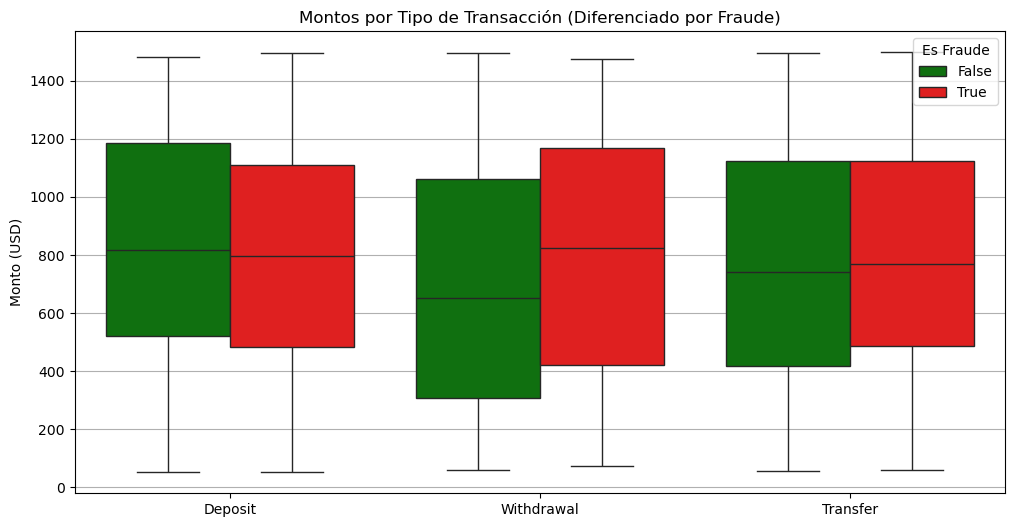

In [158]:
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=df,
    x='Transaction Type',
    y='Transaction Amount',
    hue='Fraud Flag',
    palette={True: 'red', False: 'green'},
    showfliers=False
)
plt.title('Montos por Tipo de Transacción (Diferenciado por Fraude)')
plt.legend(title='Es Fraude', loc='upper right')
plt.ylabel('Monto (USD)')
plt.xlabel('')
plt.grid(axis='y')
plt.show()

casi la mitad de operaciones se marcaron como fraude, los depositos fueron los que más se consideraron como fraude, no hubo ubicaciones fuera del rango para considerarlo peligroso, ya que todos se realizaron en los mismos lugares,los dispositivos con mayor tendencia a fraude son los registrados en celular, la red 1 es la que menor fraude registra, la 2 y 3 es donde se concentra más casos, entre más latencia se eleva muy ligero que pase la probabilidad de falla. la mitad de transacciones no se pudieron realizar, la reacion entre ancho de banda y latencia se mantuvo estable y no se observarion tendencias, donde se realizaron mayores transacciones fue entre los 20 y 30 min/ 50 a 60 min
